# Stroke Prediction Analysis

This notebook analyzes a dataset of patient information to predict stroke risk using various machine learning models. The data analysis will be done and models will be learned.

 ## Imports

All of the imported packages can be installed using `pip install -r ./requirements.txt`.

In [25]:
# import joblib # imported in cell with actual model saving
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, \
    classification_report
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [26]:
# Run only if you want to suppress warnings
import warnings

warnings.filterwarnings('ignore')  # Ignore warnings

The imported packages are rather standard machine learning or plotting packages: `matplotlib`, `pandas`, `numpy`, `seaborn` as well as `scikit-learn`.

---

Package `imblearn` is not available at `jupyter.vse.cz` installation. This package is used because the input data is rather imbalanced (only about 5 % of input data is with stroke occurrence). This can lead to the situation that trained model will just predict that person will just not experience a stroke (like `return False`) and still be accurate in about 95 % of cases. Package `imblearn` and its SMOTE technique is able to create new examples based on interpolating of existing examples.

---

Package `warnings` is used to suppress warning messages of used libraries. It is not crucial and if the corresponding cell will not be run, no change to actual results will happen.

---

Package `joblib` is used to save the best model. See the section [## Save best model](#save-best-model) and its code. If it will not be executed, nothing will really happen - well the model will not be saved into the file, but it will be trained already and ready to use.

## Exploratory Data Analysis

Load the dataset into dataframe `df` variable and perform basic data analysis

In [27]:
df = pd.read_csv("stroke_input.csv")  # Load the dataset from CSV file
df.head()  # Display the first 5 rows to understand the structure and contents

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [28]:
print(f"\nDataset shape: {df.shape}")  # Check dataset dimensions: number of rows and columns

print("\nDistribution")  # Check class distribution for the target variable 'stroke'
print(df['stroke'].value_counts())  # Count of patients with and without stroke
print(df['stroke'].value_counts(normalize=True) * 100)  # in percents 

print("\nNull values")  # Check for missing values in each column
print(df.isnull().sum())  # Important for preprocessing (e.g., 'bmi' column has missing values)


Dataset shape: (5110, 12)

Distribution
stroke
0    4861
1     249
Name: count, dtype: int64
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64

Null values
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


It can be seen that just only about 5 % of the entire dataset is with stroke occurrence. This imbalance is tackled using `imblearn SMOTE` package. See section [## Training models](#training-models) and its pipeline creation part.

### Correlation Analysis

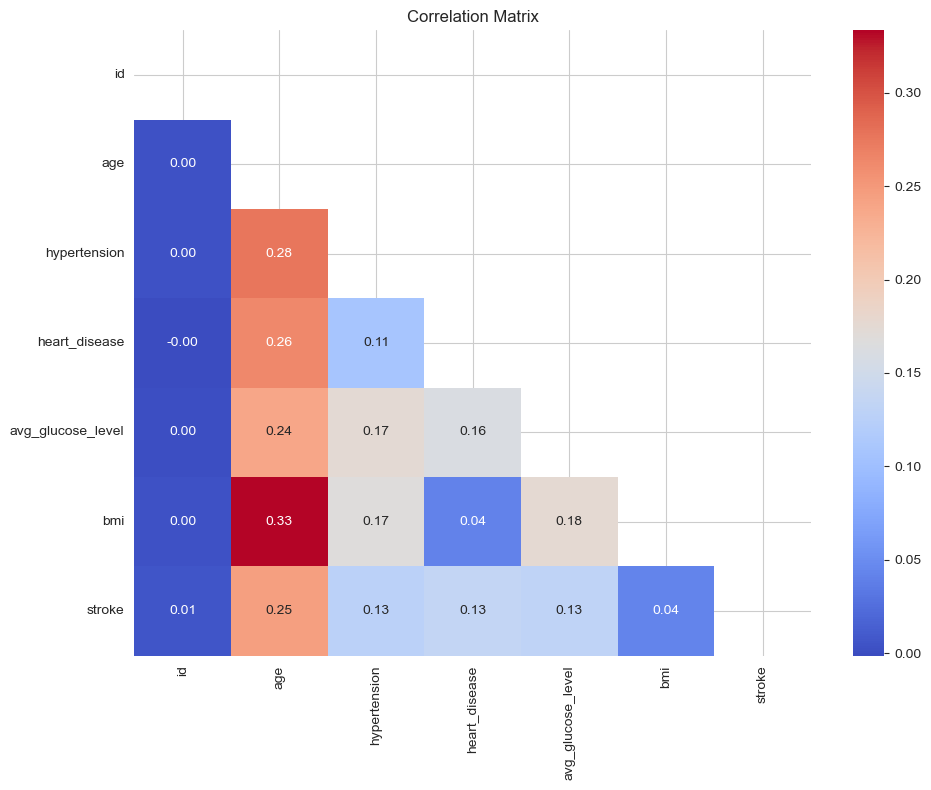

In [29]:
plt.figure(figsize=(10, 8))
correlation = df.select_dtypes(include=['number']).corr()  # Compute correlation matrix for numeric columns only
mask = np.triu(correlation)  # Create a mask to display only the lower triangle of the matrix (for clarity)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm",
            mask=mask)  # Plot the heatmap with annotations and color gradients
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### Numerical Features Analysis

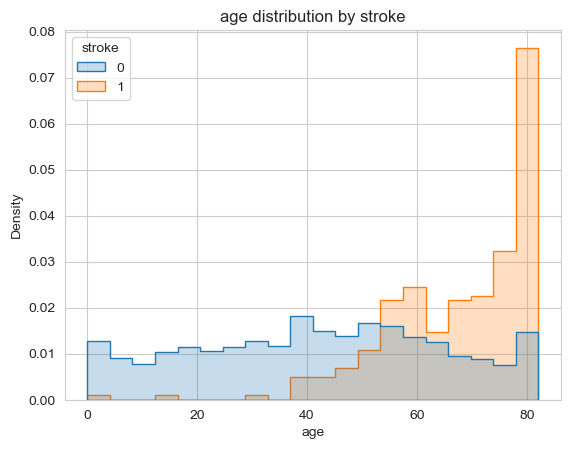

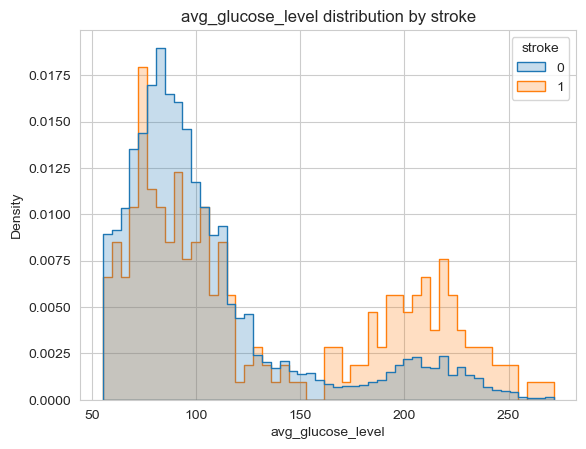

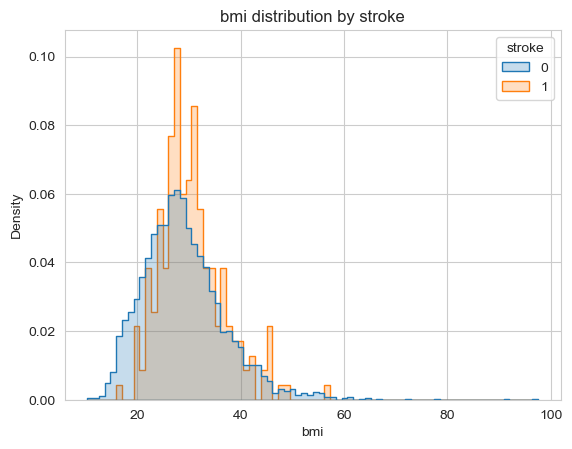

In [30]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']  # Define the numerical features to visualize
for feature in numerical_features:  # Loop through each feature and plot its distribution for stroke vs. non-stroke
    sns.histplot(data=df, x=feature, hue='stroke', element='step', stat='density', common_norm=False)
    plt.title(f'{feature} distribution by stroke')

    plt.show()

### Categorical Features Analysis

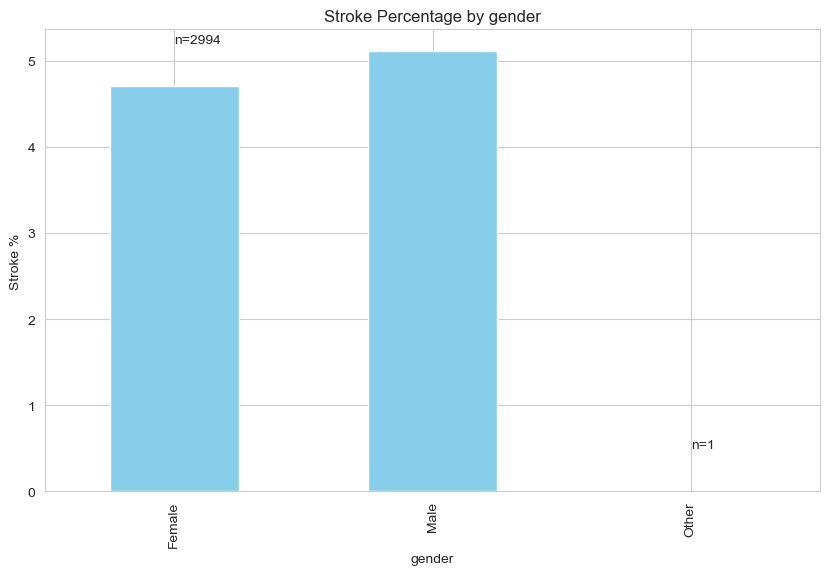


Contingency table for gender:
stroke     0    1
gender           
Female  2853  141
Male    2007  108
Other      1    0

Percentage table:
stroke           0         1
gender                      
Female   95.290581  4.709419
Male     94.893617  5.106383
Other   100.000000  0.000000


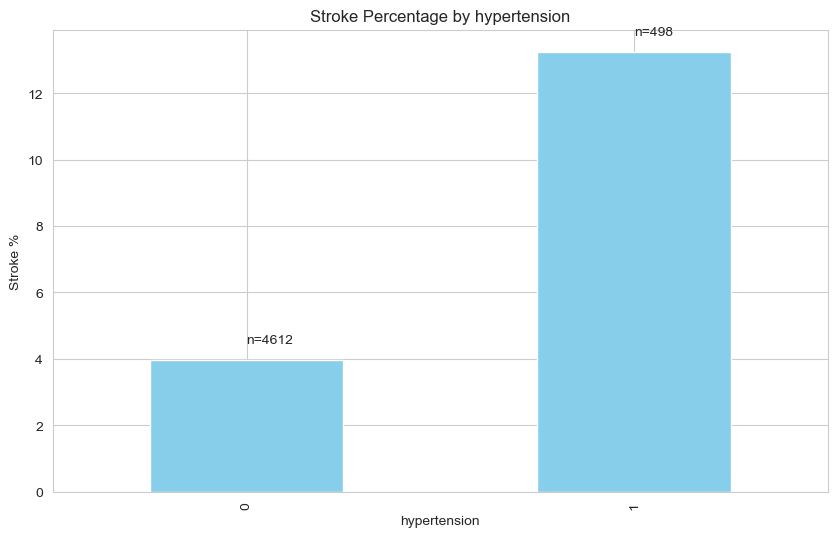


Contingency table for hypertension:
stroke           0    1
hypertension           
0             4429  183
1              432   66

Percentage table:
stroke                0          1
hypertension                      
0             96.032090   3.967910
1             86.746988  13.253012


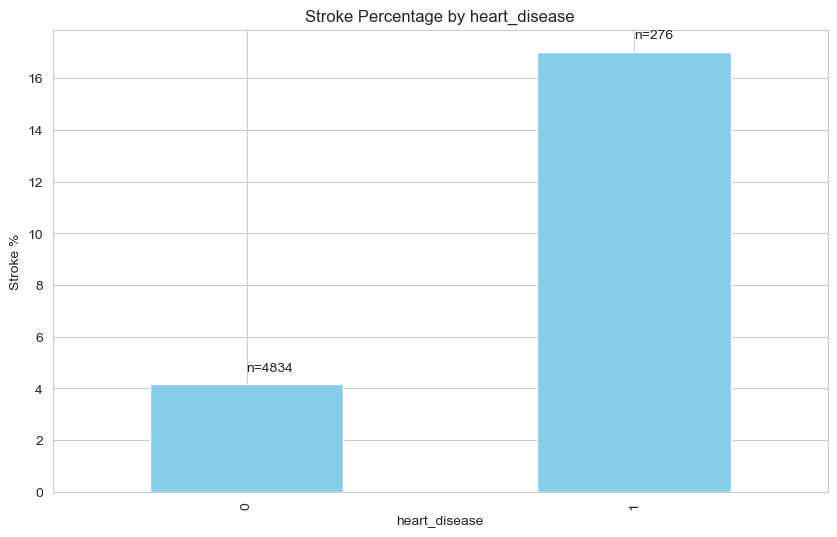


Contingency table for heart_disease:
stroke            0    1
heart_disease           
0              4632  202
1               229   47

Percentage table:
stroke                 0          1
heart_disease                      
0              95.821266   4.178734
1              82.971014  17.028986


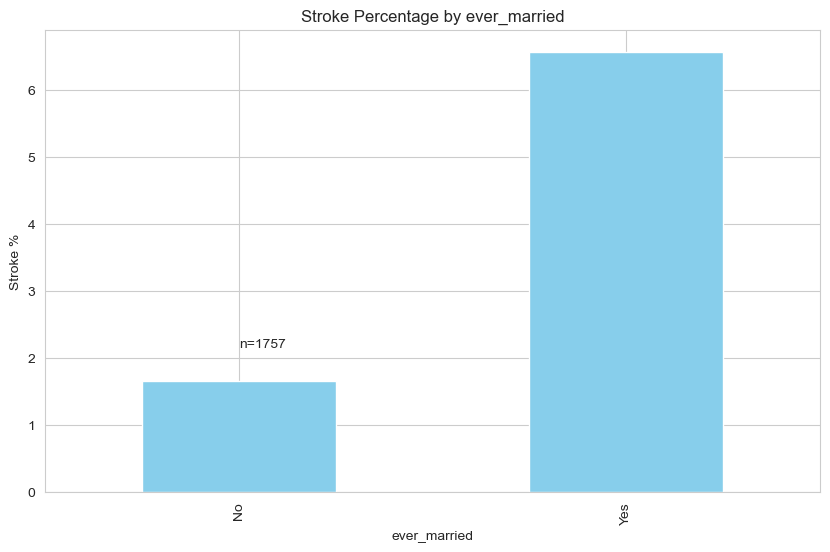


Contingency table for ever_married:
stroke           0    1
ever_married           
No            1728   29
Yes           3133  220

Percentage table:
stroke                0         1
ever_married                     
No            98.349459  1.650541
Yes           93.438712  6.561288


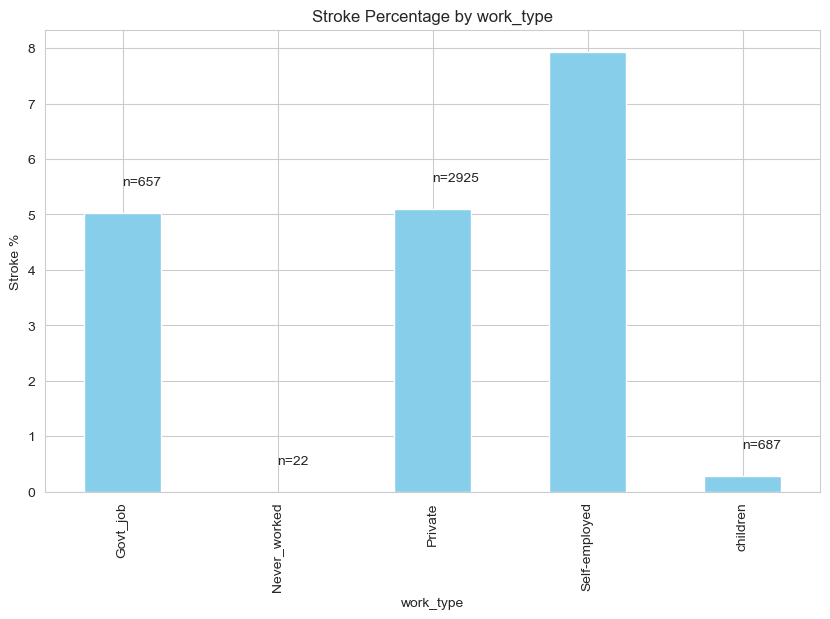


Contingency table for work_type:
stroke            0    1
work_type               
Govt_job        624   33
Never_worked     22    0
Private        2776  149
Self-employed   754   65
children        685    2

Percentage table:
stroke                  0         1
work_type                          
Govt_job        94.977169  5.022831
Never_worked   100.000000  0.000000
Private         94.905983  5.094017
Self-employed   92.063492  7.936508
children        99.708879  0.291121


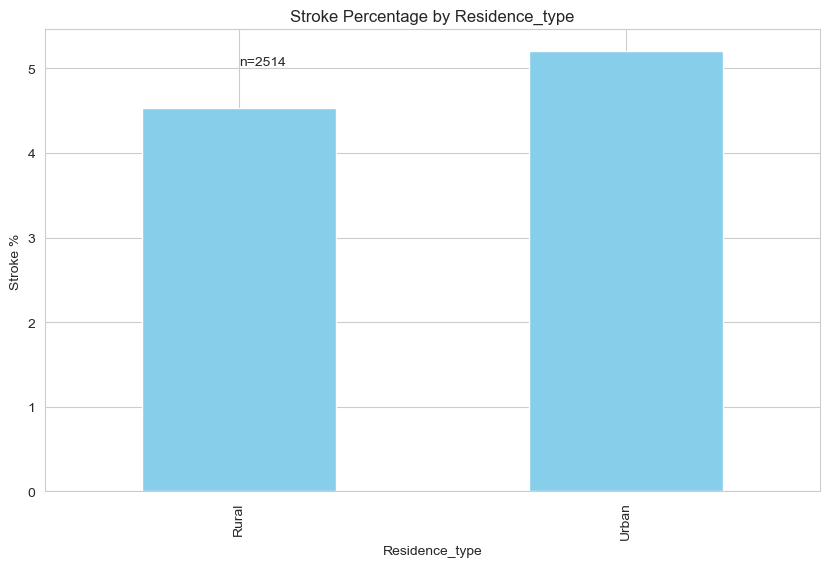


Contingency table for Residence_type:
stroke             0    1
Residence_type           
Rural           2400  114
Urban           2461  135

Percentage table:
stroke                  0         1
Residence_type                     
Rural           95.465394  4.534606
Urban           94.799692  5.200308


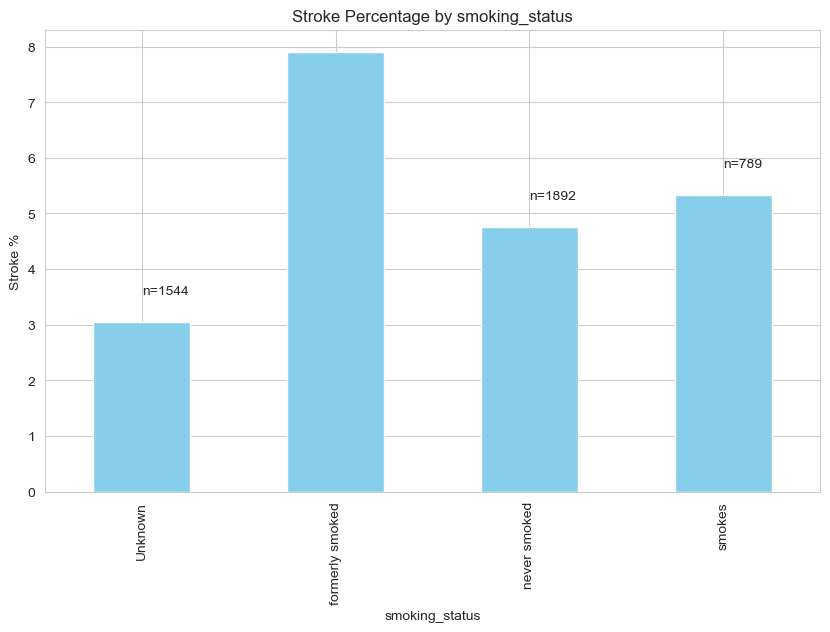


Contingency table for smoking_status:
stroke              0   1
smoking_status           
Unknown          1497  47
formerly smoked   815  70
never smoked     1802  90
smokes            747  42

Percentage table:
stroke                   0         1
smoking_status                      
Unknown          96.955959  3.044041
formerly smoked  92.090395  7.909605
never smoked     95.243129  4.756871
smokes           94.676806  5.323194


In [31]:
categorical_features = [
    'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
]  # List of categorical variables to analyze

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    stroke_percent = df.groupby(feature)[
                         'stroke'].mean() * 100  # Calculate stroke rate (%) for each category in the feature

    axis = stroke_percent.plot(kind='bar', color='skyblue')  # Create bar plot showing stroke percentage by category
    plt.title(f'Stroke Percentage by {feature}')
    plt.ylabel('Stroke %')

    for i, p in enumerate(axis.patches):  # Add labels showing number of observations per category
        category = stroke_percent.index[i]
        count = df[df[feature] == category].shape[0]
        axis.annotate(f'n={count}', (i, p.get_height() + 0.5))

    plt.show()

    contingency = pd.crosstab(df[feature],
                              df['stroke'])  # Print the contingency table (raw counts of stroke vs. non-stroke)
    print(f"\nContingency table for {feature}:")
    print(contingency)
    print(f"\nPercentage table:")  # Print the percentage distribution of stroke by category
    print(pd.crosstab(df[feature], df['stroke'], normalize='index') * 100)

## Data Preprocessing

In [32]:
df_old = pd.read_csv("stroke_input.csv")  # Reload original data to keep raw version safe
df = df_old.copy()

# ID is not important
df.drop(columns=["id"], inplace=True)

# Only one other genre - can be removed
df = df[df['gender'] != 'Other']

# `gender` to binary
df['is_male'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df.drop(columns=["gender"], inplace=True)

# `ever_married` to binary
df['ever_married'] = df['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)

# `residence` to binary
df['is_urban_resident'] = df['Residence_type'].apply(lambda x: 1 if x == 'Urban' else 0)
df.drop(columns=["Residence_type"], inplace=True)

# Age categories from `age`
df['age_category'] = pd.cut(
    df['age'], bins=[0, 18, 40, 60, 80, 999], labels=['0-18', '19-40', '41-60', '61-80', '81+']
)
df.drop(columns=["age"], inplace=True)

# Missing `bmi` fill with median value of BMI
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# BMI categories from `bmi`
df['bmi_category'] = pd.cut(
    df['bmi'], bins=[0, 18.5, 25, 30, 999], labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)
df.drop(columns=["bmi"], inplace=True)

# Glucose categories from `avg_glucose_level`
df['glucose_category'] = pd.cut(
    df['avg_glucose_level'], bins=[0, 70, 100, 125, 999], labels=['Low', 'Normal', 'Prediabetic', 'Diabetic']
)
df.drop(columns=["avg_glucose_level"], inplace=True)

print("\nBefore preprocessing:")  # preview before and after transformation
df_old.head()

print("\nAfter preprocessing:")
df.head()


Before preprocessing:

After preprocessing:


hypertension  heart_disease  ever_married      work_type   smoking_status  \
0             0              1             1        Private  formerly smoked   
1             0              0             1  Self-employed     never smoked   
2             0              1             1        Private     never smoked   
3             0              0             1        Private           smokes   
4             1              0             1  Self-employed     never smoked   

   stroke  is_male  is_urban_resident age_category bmi_category  \
0       1        1                  1        61-80        Obese   
1       1        0                  0        61-80   Overweight   
2       1        1                  0        61-80        Obese   
3       1        0                  1        41-60        Obese   
4       1        0                  0        61-80       Normal   

  glucose_category  
0         Diabetic  
1         Diabetic  
2      Prediabetic  
3         Diabetic  
4         Diabetic

## Plot functions

Definition of plotting functions that are used in the following code.

In [33]:
def plot_confusion_matrix(y_true, y_pred, title):  # Plot confusion matrix as a heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true, y_pred))  # Print precision, recall, F1-score


def plot_roc_curves(models_dict, X_test, y_test):  # Plot ROC curves for multiple models
    plt.figure(figsize=(12, 8))

    for name, model in models_dict.items():  # Predict probabilities for class 1 (stroke)
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Add reference line
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curves')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def feature_importance_plot(model, feature_names):  # Plot feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12, 8))
        plt.title('Feature importances')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
        plt.xlim([-1, len(indices)])
        plt.tight_layout()
        plt.show()


def plot_tree_diagram(model, feature_names, model_name):  # Visualize individual decision trees from ensemble models
    if model_name == "Random Forest" and hasattr(model, "estimators_"):
        estimator = model.estimators_[0]
        plt.figure(figsize=(20, 10))
        plot_tree(estimator, feature_names=feature_names, filled=True, max_depth=3, fontsize=10)
        plt.title("Random forest tree")
        plt.show()

    elif model_name == "Gradient Boosting" and hasattr(model, "estimators_"):
        estimator = model.estimators_[0, 0]
        plt.figure(figsize=(20, 10))
        plot_tree(estimator, feature_names=feature_names, filled=True, max_depth=3, fontsize=10)
        plt.title("Gradient boosting tree")
        plt.show()

    else:
        print(f"Tree plotting not supported for model: {model_name}")

## Feature creating, dataset split

In [34]:
# Separate features and target
X = df.drop(columns=['stroke'])
y = df['stroke']

# Identify feature groups
binary_features = ['hypertension', 'heart_disease', 'is_male', 'ever_married', 'is_urban_resident']
categorical_features = ['work_type', 'smoking_status', 'age_category', 'bmi_category', 'glucose_category']

# Create a preprocessing pipeline
# Binary: OrdinalEncoder will map 0/1 cleanly
# Categorical: OneHotEncoder drops the first category to avoid multicollinearity
preprocessor = ColumnTransformer(
    [
        ('bin', OrdinalEncoder(), binary_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

# get feature names # Fit OneHotEncoder separately to extract new feature names
cat_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
cat_encoder.fit(X[categorical_features])
encoded_cat_features = list(cat_encoder.get_feature_names_out(categorical_features))
feature_names = binary_features + encoded_cat_features  # Final list of feature names after encoding

# Split the dataset into training and testing sets (80/20)
# Stratify ensures equal stroke/non-stroke proportion in both sets
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Basic shape and balance checks
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Stroke prevalence in training set: {y_train.mean():.2%}")
print(f"Stroke prevalence in testing set: {y_test.mean():.2%}")

Training set shape: (4087, 10)
Testing set shape: (1022, 10)
Stroke prevalence in training set: 4.87%
Stroke prevalence in testing set: 4.89%


## Training preparation

### Why these hyperparameters?

For each model, we selected commonly used and relevant hyperparameters that significantly affect performance:

- **Logistic Regression**:
  - `C`: Controls regularization strength. We test both low (0.01) and high (10) values to prevent overfitting or underfitting.
  - `solver`: `liblinear` is reliable for small datasets; `saga` supports larger-scale L1/L2 regularization.

- **Random Forest**:
  - `n_estimators`: Number of trees. More trees can increase performance but also computation time.
  - `max_depth`: Controls how deep trees can grow — helps prevent overfitting.
  - `min_samples_split`, `min_samples_leaf`: Control how many samples are required to split nodes and define leaf size, improving generalization.

- **Gradient Boosting**:
  - `n_estimators`: Number of boosting stages — more stages can improve accuracy but risk overfitting.
  - `learning_rate`: Controls how much each tree influences the final prediction — lower values mean slower, more careful learning.
  - `max_depth`: Limits tree complexity, prevents overfitting.
  - `subsample`: Controls fraction of data used for each tree — reduces variance and increases robustness.

- **K-Nearest Neighbors (KNN)**:
  - `n_neighbors`: Number of neighbors to consider — affects bias/variance tradeoff.
  - `weights`: `uniform` gives equal weight to neighbors, while `distance` gives more influence to closer neighbors.
  - `p`: Distance metric — `p=1` is Manhattan, `p=2` is Euclidean.

These parameter ranges are chosen to give a wide yet reasonable search space, covering both conservative and aggressive configurations for each algorithm.


In [35]:

# Define models to be trained
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Define hyperparameters for GridSearchCV
model_parameters = {
    "Logistic Regression": {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['liblinear', 'saga']
    },
    "Random Forest": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    "Gradient Boosting": {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5],
        'classifier__subsample': [0.8, 1.0]
    },
    "KNN": {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]  # Manhattan or Euclidean
    }
}

# Define stratified cross-validation to preserve class ratios across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Prepare output variables:

In [36]:
best_models = {}
results = []

## Training models


Training Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Logistic Regression parameters: {'classifier__C': 0.01, 'classifier__solver': 'liblinear'}
Best cross-validation ROC AUC: 0.8084


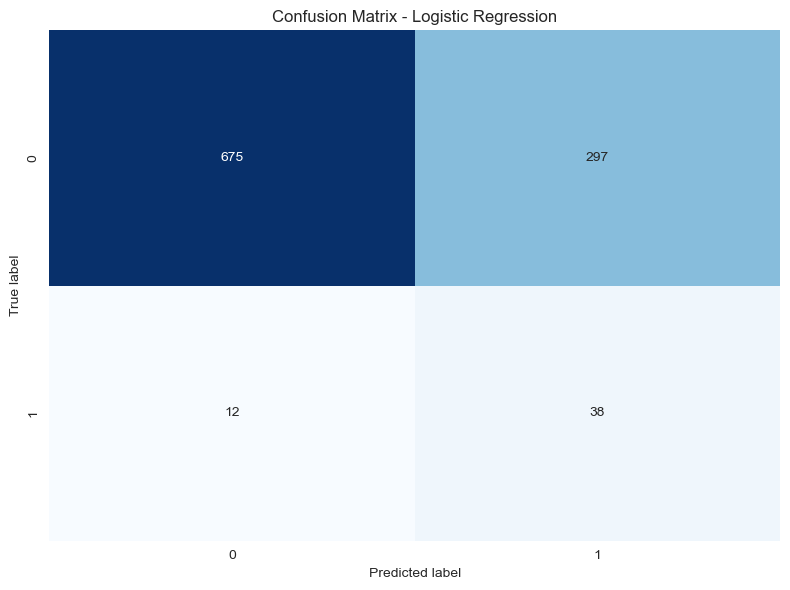

              precision    recall  f1-score   support

           0       0.98      0.69      0.81       972
           1       0.11      0.76      0.20        50

    accuracy                           0.70      1022
   macro avg       0.55      0.73      0.51      1022
weighted avg       0.94      0.70      0.78      1022


Training Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Random Forest parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation ROC AUC: 0.7981


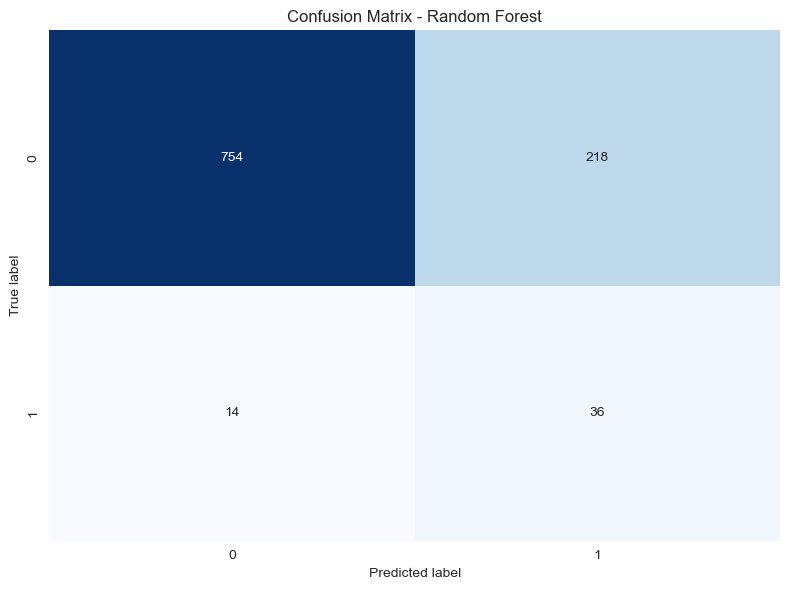

              precision    recall  f1-score   support

           0       0.98      0.78      0.87       972
           1       0.14      0.72      0.24        50

    accuracy                           0.77      1022
   macro avg       0.56      0.75      0.55      1022
weighted avg       0.94      0.77      0.84      1022


Training Gradient Boosting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Gradient Boosting parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best cross-validation ROC AUC: 0.8022


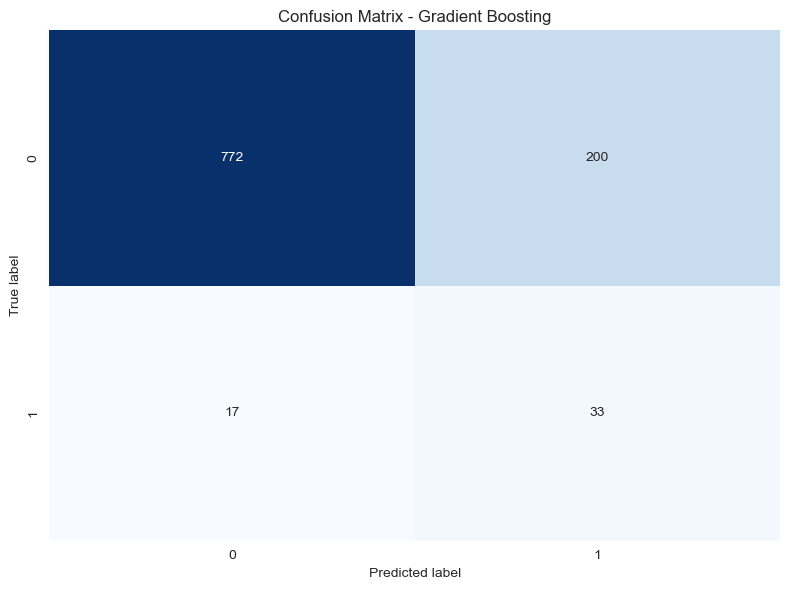

              precision    recall  f1-score   support

           0       0.98      0.79      0.88       972
           1       0.14      0.66      0.23        50

    accuracy                           0.79      1022
   macro avg       0.56      0.73      0.55      1022
weighted avg       0.94      0.79      0.85      1022


Training KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best KNN parameters: {'classifier__n_neighbors': 9, 'classifier__p': 2, 'classifier__weights': 'uniform'}
Best cross-validation ROC AUC: 0.7380


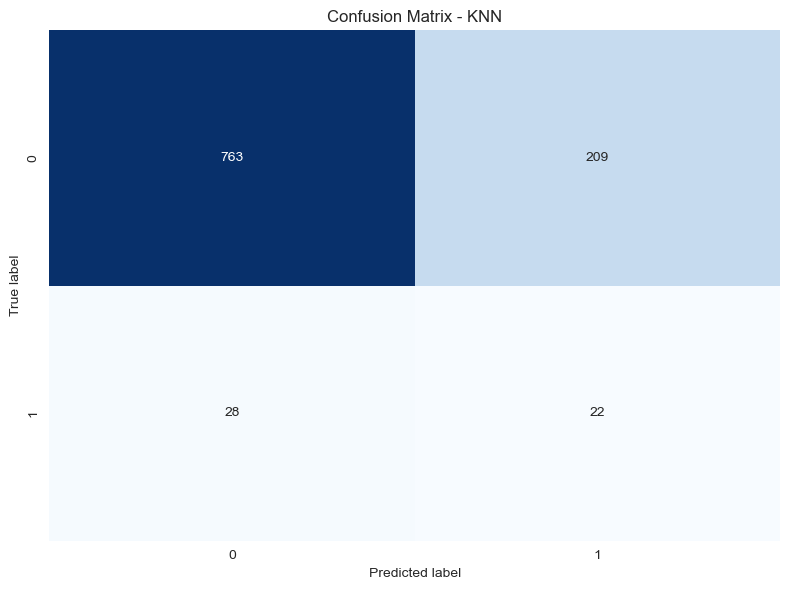

              precision    recall  f1-score   support

           0       0.96      0.78      0.87       972
           1       0.10      0.44      0.16        50

    accuracy                           0.77      1022
   macro avg       0.53      0.61      0.51      1022
weighted avg       0.92      0.77      0.83      1022


Training Naive Bayes...


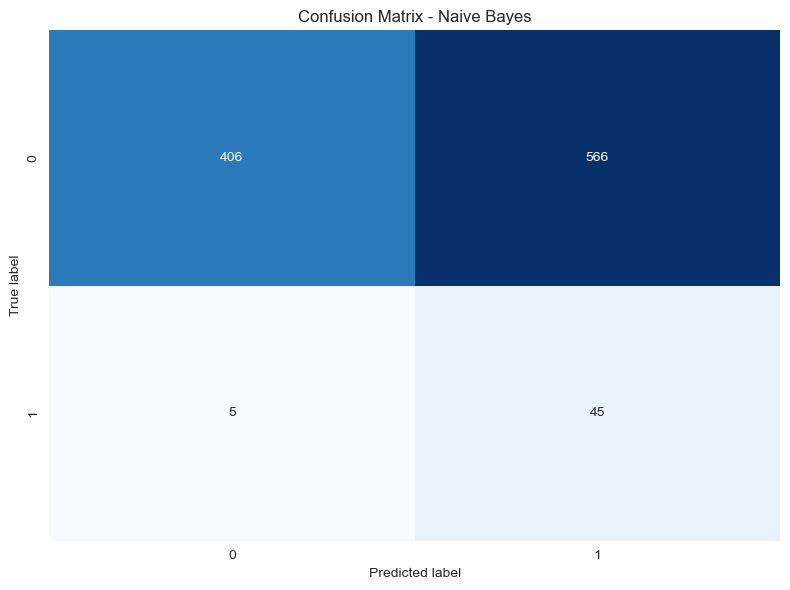

              precision    recall  f1-score   support

           0       0.99      0.42      0.59       972
           1       0.07      0.90      0.14        50

    accuracy                           0.44      1022
   macro avg       0.53      0.66      0.36      1022
weighted avg       0.94      0.44      0.57      1022



In [37]:
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Define the full pipeline for this model # Transform features # Balance classes # ML model
    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),  # Handle class imbalance by creating synthetic samples
        ('classifier', model)
    ])

    # Tuning cross-validation  # Check if this model has defined hyperparameters for tuning # Apply GridSearchCV for hyperparameter tuning # Parameter grid specific to the model  # 5-fold stratified cross-validation # Use AUC for model comparison
    if name in model_parameters:
        grid_search = GridSearchCV(
            pipe, model_parameters[name], cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1
        )
        grid_search.fit(X_train, y_train)

        # Save the best pipeline
        best_model = grid_search.best_estimator_
        print(f"Best {name} parameters: {grid_search.best_params_}")
        print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")

    else:
        # Naive bayes
        best_model = pipe
        best_model.fit(X_train, y_train)

    # Save the best model
    best_models[name] = best_model

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Store evaluation results
    results.append({
        "Model": name,
        "ROC AUC": roc_auc,
        "F1": f1,
        "Precision": precision,
        "Recall": recall
    })

    # Visual feedback
    plot_confusion_matrix(y_test, y_pred, f"Confusion Matrix - {name}")

## Tree based models graphs


Tree graph for Random Forest:


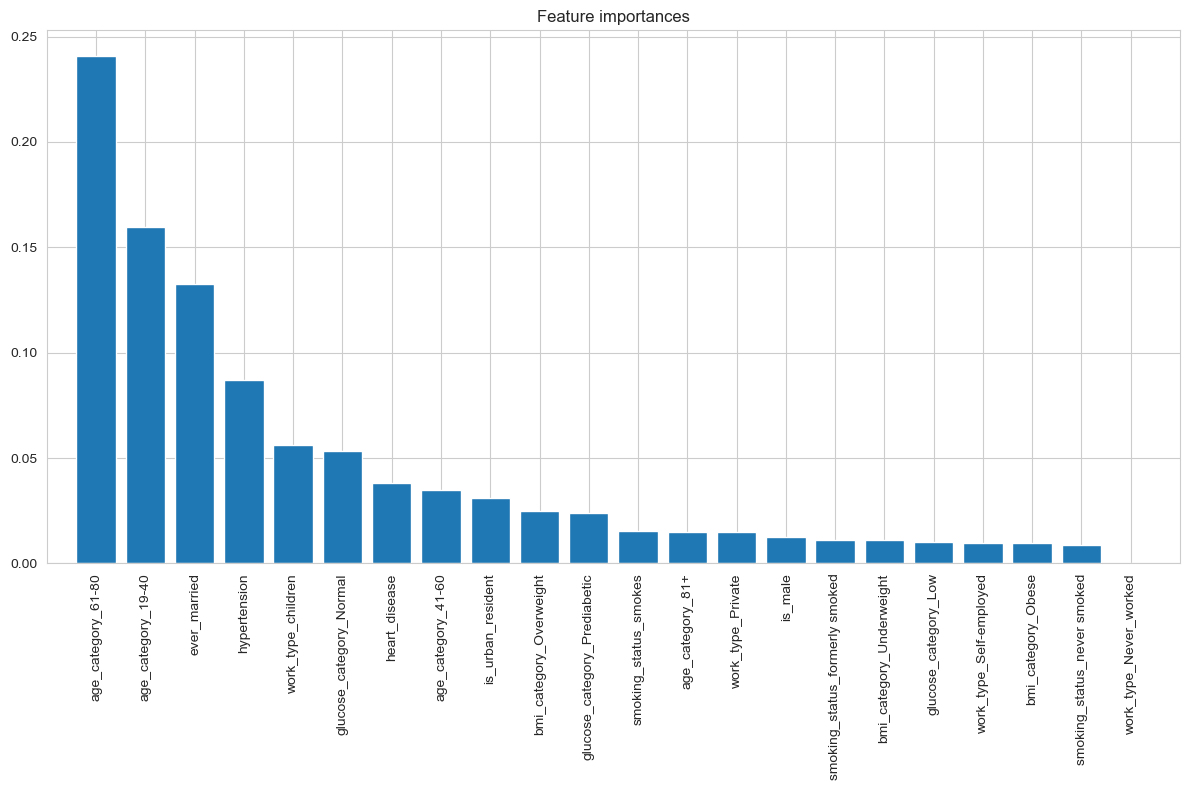

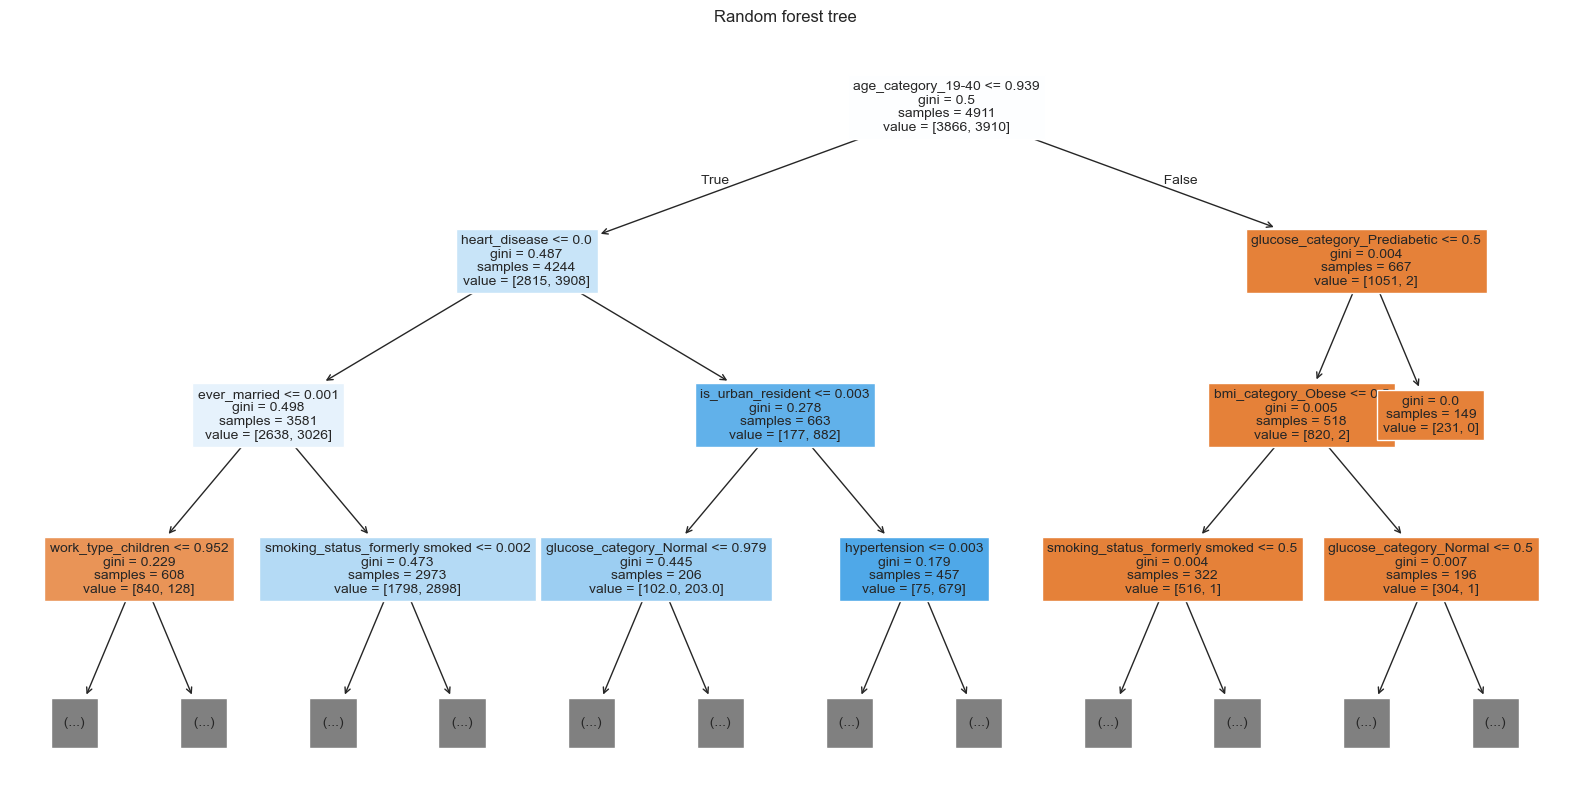


Tree graph for Gradient Boosting:


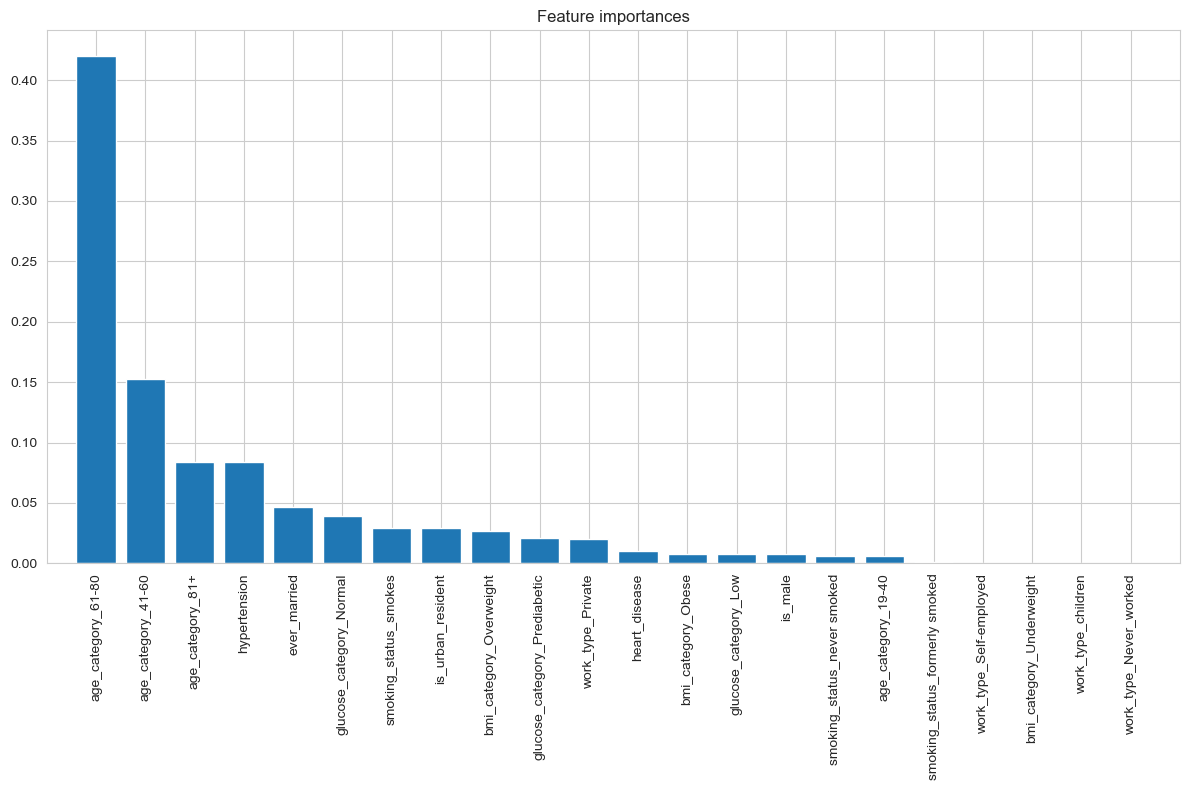

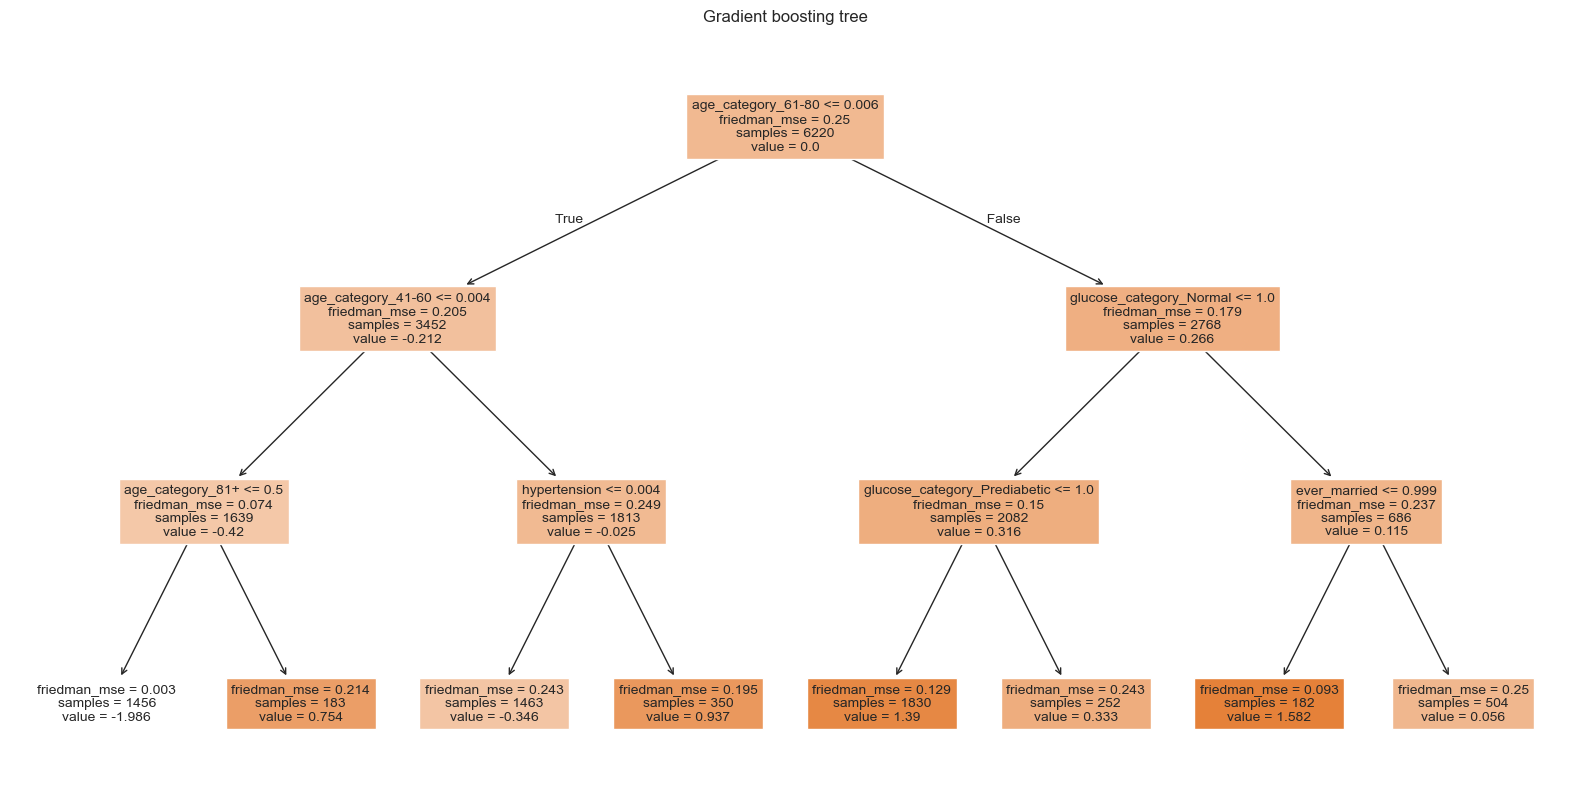

In [38]:
# Plot feature importance and decision tree structure for tree-based models
for name in ["Random Forest", "Gradient Boosting"]:
    if name in best_models:
        print(f"\nTree graph for {name}:")

        # Bar chart of feature importance
        feature_importance_plot(best_models[name].named_steps["classifier"], feature_names)

        # Visualize a single tree in the ensemble
        plot_tree_diagram(best_models[name].named_steps["classifier"], feature_names, name)


## Model Comparison


Model Comparison:
              Model  ROC AUC       F1  Precision  Recall
  Gradient Boosting 0.810514 0.233216   0.141631    0.66
        Naive Bayes 0.804270 0.136157   0.073650    0.90
Logistic Regression 0.802438 0.197403   0.113433    0.76
      Random Forest 0.786924 0.236842   0.141732    0.72
                KNN 0.731842 0.156584   0.095238    0.44


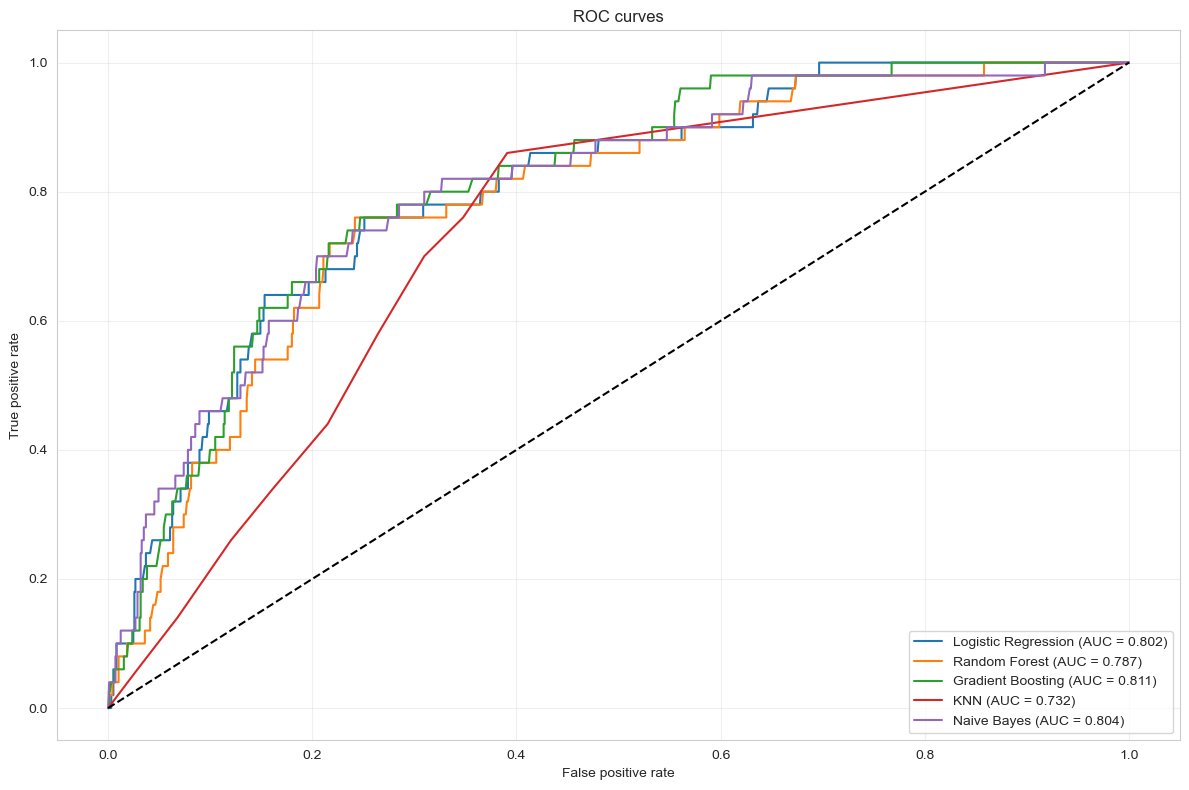

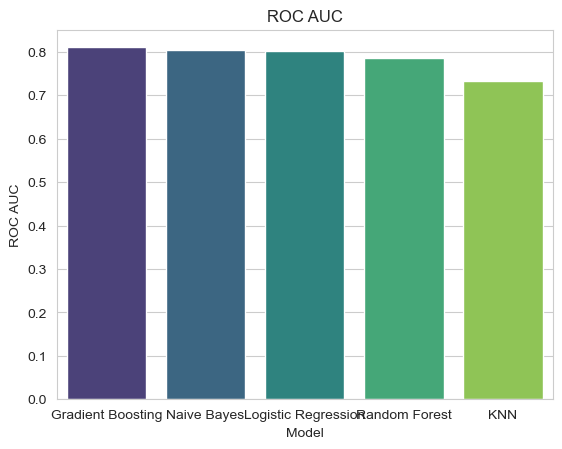

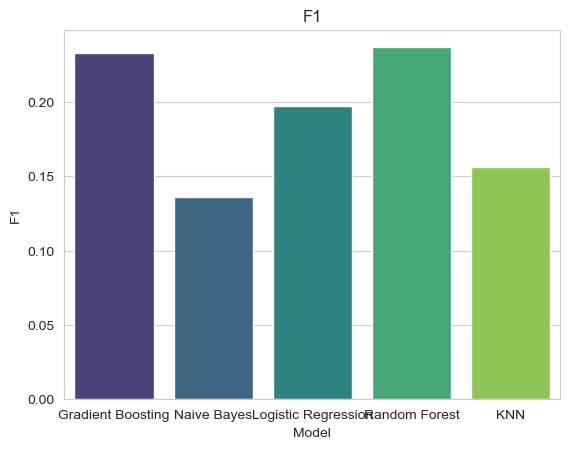

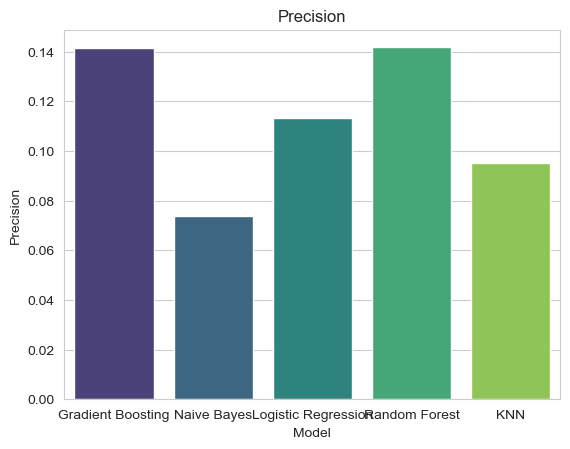

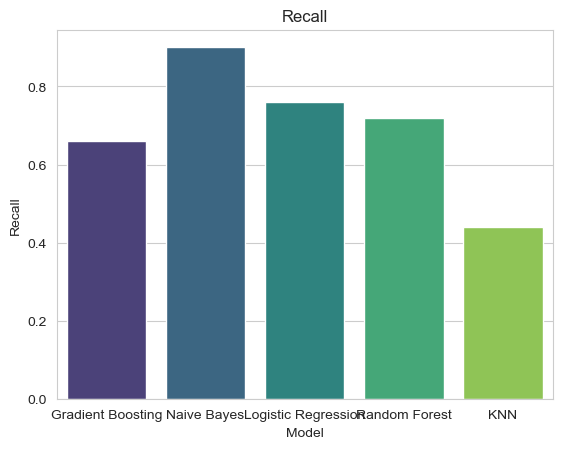


Best model: Gradient Boosting


In [39]:
# Extract metric names (ROC AUC, F1, etc.)
metrics = results[0].keys()

# Get best model by ROC AUC
results_df = pd.DataFrame(results).sort_values(by="ROC AUC", ascending=False)

print("\nModel Comparison:")
print(results_df.to_string(index=False))

# Plot ROC curves for all models
plot_roc_curves(best_models, X_test, y_test)

# Bar plots for each metric across models
for i, metric in enumerate(metrics):
    if metric == "Model":
        continue
    sns.barplot(x="Model", y=metric, data=results_df, palette="viridis")
    plt.title(f"{metric}")
    plt.show()

# Save the best model (top performer based on ROC AUC)
best_model_name = results_df.iloc[0]["Model"]  # sorted, best model on first place
best_model = best_models[best_model_name]  # save best model to its own variable for easier access
print(f"\nBest model: {best_model_name}")

## Save Best Model

By executing following cell you can save the best model

In [40]:
import joblib

joblib.dump(best_model, "model.pkl")

['model.pkl']

## Examine yourself

By executing following cell, you can examine yourself by entering your own data into the best trained model.

In [41]:
def predict_stroke_risk(model):
    hypertension = 1 if input("Do you have hypertension? (yes/no): ").lower() == 'yes' else 0
    heart_disease = 1 if input("Do you have heart disease? (yes/no): ").lower() == 'yes' else 0
    is_male = 1 if input("Are you male? (yes/no): ").lower() == 'yes' else 0
    ever_married = 1 if input("Have you ever been married? (yes/no): ").lower() == 'yes' else 0
    is_urban_resident = 1 if input("Do you live in an urban area? (yes/no): ").lower() == 'yes' else 0

    work_options = list(set(df['work_type'].unique()))
    input_string = f"Select your work type (1-{len(work_options)}): \n"
    for i, option in enumerate(work_options):
        input_string += f"{i + 1}) {option}\n"
    work_choice = int(input(input_string))
    work_type = work_options[work_choice - 1]

    smoking_options = list(set(df['smoking_status'].unique()))
    input_string = f"\nSelect your smoking status (1-{len(smoking_options)}): \n"
    for i, option in enumerate(smoking_options):
        input_string += f"{i + 1}) {option}\n"
    smoking_choice = int(input(input_string))
    smoking_status = smoking_options[smoking_choice - 1]

    age_options = list(set(df['age_category'].unique()))
    input_string = f"\nSelect your age category (1-{len(age_options)}): \n"
    for i, option in enumerate(age_options):
        input_string += f"{i + 1}) {option}\n"
    age_choice = int(input(input_string))
    age_category = age_options[age_choice - 1]

    bmi_options = list(set(df['bmi_category'].unique()))
    input_string = f"\nSelect your BMI category (1-{len(bmi_options)}): \n"
    for i, option in enumerate(bmi_options):
        input_string += f"{i + 1}) {option}\n"
    bmi_choice = int(input(input_string))
    bmi_category = bmi_options[bmi_choice - 1]

    glucose_options = list(set(df['glucose_category'].unique()))
    input_string = f"\nSelect your glucose level category (1-{len(glucose_options)}): \n"
    for i, option in enumerate(glucose_options):
        input_string += f"{i + 1}) {option}\n"
    glucose_choice = int(input(input_string))
    glucose_category = glucose_options[glucose_choice - 1]

    user_data = pd.DataFrame({
        'hypertension': [hypertension],
        'heart_disease': [heart_disease],
        'is_male': [is_male],
        'ever_married': [ever_married],
        'is_urban_resident': [is_urban_resident],
        'work_type': [work_type],
        'smoking_status': [smoking_status],
        'age_category': [age_category],
        'bmi_category': [bmi_category],
        'glucose_category': [glucose_category]
    })

    stroke_probability = model.predict_proba(user_data)[0, 1]
    prediction = "High risk" if stroke_probability > 0.5 else "Low risk"

    print(f"Stroke probability: {stroke_probability:.2%}")
    print(f"Risk category: {prediction}")


predict_stroke_risk(best_model)

Stroke probability: 9.67%
Risk category: Low risk
